# Can the health and nutritional status of adults and children be used to classify age group?

### Data set: National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset

# 1. Summary

link: https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset

# 2. Introduction

While taking care of elders is a core value of many cultures, this is not a hallmark of many western societies, including the Unites States (Healthy Aging Center 2022). Is it possible that this is reflected in different health measures? Put another way, could we use health measures to predict whether an American is a senior or not?

Formally, the question this project seeks to answer is: Can information about the health and nutritional status of Americans be used to predict whether they are adults or seniors?

The dataset used to answer this question is the National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset. It was originally prepared for a research paper on predicting diabetes and cardiovascular disease in patients (Dinh and Miertschin 2016). The dataset's stated purpose was to assess the health and nutritional status of adults and children in the United States, however respondents were classified as either Adults (respondents under 65 years of age) or Seniors (respondents 65 years of age or older). Respondents were located in the United States and provided data through interviews, physical examinations, and laboratory tests to the National Center for Health Statistics (NCHS) (part of the Centers for Disease Control and Prevention (CDC)).

The dataset has 10 variables and 2278 rows, with each row representing a respondent. The variables are:
1. SEQN - The respondent ID aka sequence number
2. age_group - The respondent's age group (adult or senior)
3. RIDAGEYR - The respondent's age in years
4. RIAGENDR - The respondent's gender (1 represents Male, 2 represents Female)
5. PAQ605 - Whether the respondent engages in weekly moderate or vigorous physical activity (1 means they do, 2 means they don't)
6. BMXBMI - The respondent's body mass index
7. LBXGLU - The respondent's blood glucose after fasting
8. DIQ010 - Whether the respondent is diabetic (1 is yes, 2 is no)
9. LBXGLT - A measure of the respondent's oral health
10. LBXIN - The respondent's blood insulin levels

According to the dataset description, there are no missing values, though EDA found some unexpected values for physical activity and diabetic. Since no explanation was provided for these codes, we omitted these respondent's from our analysis.

# 3. Methods & Results

### 3.1 Description of Methods
We loaded and cleaned the data, first renaming columns for clarity. We then found values for physical activity and diabetic variables that were not explained in the dataset's documentation and decided to remove observations with those values. Next we confirmed the that the dataset's description of no missing values was accurate, then split the data into training and test, and conducted EDA on the training set - including examining summary statistics of each variable and plotting their distributions.

For our analysis, we first transformed categorical variables with one hot encoding, and standardized the scales of numeric variables. Because there were no missing values, it was not necessary to do transformations for this. We then fit 3 models (a dummy classifier, a linear classifier, and SVC) to the test data, and selected SVC for our final analysis because it had the best cross-validation scores. Finally, we used our SVC model to predict the test data and visualized how the model performed on this data.

### 3.2 Imports & Loading the Data

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
nhanes = fetch_ucirepo(id=887) 

In [3]:
print(nhanes.variables)

        name     role         type demographic  \
0       SEQN       ID   Continuous        None   
1  age_group   Target  Categorical         Age   
2   RIDAGEYR    Other   Continuous         Age   
3   RIAGENDR  Feature   Continuous      Gender   
4     PAQ605  Feature   Continuous        None   
5     BMXBMI  Feature   Continuous        None   
6     LBXGLU  Feature   Continuous        None   
7     DIQ010  Feature   Continuous        None   
8     LBXGLT  Feature   Continuous        None   
9      LBXIN  Feature   Continuous        None   

                                         description units missing_values  
0                         Respondent Sequence Number  None             no  
1         Respondent's Age Group (senior/non-senior)  None             no  
2                                   Respondent's Age  None             no  
3                                Respondent's Gender  None             no  
4  If the respondent engages in moderate or vigor...  None           

### 3.3 Cleaning the data

#### Renaming columns
We first renamed the columns of the data set to be more meaningful and easy to understand. Below is a short description of each column in the data set.

- RIDAGEYR: Respondent's Age
- RIAGENDR: Respondent's Gender (1 is Male / 2 is Female)
- PAQ605: Does the respondent engage in weekly moderate or vigorous-intensity physical activity (1 is yes / 2 is no)
- BMXBMI: Respondent's Body Mass Index
- LBXGLU: Respondent's Blood Glucose after fasting
- DIQ010: If the Respondent is diabetic (1 is yes / 2 is no)
- LBXGLT: Respondent's Oral
- LBXIN: Respondent's Blood Insulin Levels

In [4]:
X = nhanes.data.features
X

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92
...,...,...,...,...,...,...,...
2273,2.0,2.0,33.5,100.0,2.0,73.0,6.53
2274,1.0,2.0,30.0,93.0,2.0,208.0,13.02
2275,1.0,2.0,23.7,103.0,2.0,124.0,21.41
2276,2.0,2.0,27.4,90.0,2.0,108.0,4.99


In [5]:
#re-naming the columns
X.columns = ["gender", 
             "physical_activity", 
             "bmi", 
             "blood_glucose", 
             "diabetic", 
             "oral", 
             "blood_insulin"]
X.head()

,gender,physical_activity,bmi,blood_glucose,diabetic,oral,blood_insulin
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [6]:
y = nhanes.data.targets
y

,age_group
0,Adult
1,Adult
2,Adult
3,Adult
4,Adult
...,...
2273,Adult
2274,Adult
2275,Adult
2276,Adult


#### Checking for strange values
We are aware that "gender", "physical_activity", "diabetic" are binary features. However, "physical_activity", "diabetic" contain three unique values instead of two.

#### physical_activity
According to the dataset's documentation, 'physical_activity' should only have 1 or 2 as values. Rows containing 7 should be imputed as NaN.

#### diabetic
According to the dataset's documentation, 'diabetic' should only have 1 or 2 as values. Rows containing 3 should be imputed as NaN.

In [7]:
X.nunique()

gender                  2
physical_activity       3
bmi                   340
blood_glucose         101
diabetic                3
oral                  232
blood_insulin        1424
dtype: int64

In [8]:
display(X['physical_activity'].unique())
display(X['diabetic'].unique())

array([2., 1., 7.])

array([2., 1., 3.])

In [9]:
data = pd.concat([X, y], axis = 1)
data_cleaned = data.query('physical_activity != 7 & diabetic != 3')
data_cleaned

,gender,physical_activity,bmi,blood_glucose,diabetic,oral,blood_insulin,age_group
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15,Adult
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult
...,...,...,...,...,...,...,...,...
2273,2.0,2.0,33.5,100.0,2.0,73.0,6.53,Adult
2274,1.0,2.0,30.0,93.0,2.0,208.0,13.02,Adult
2275,1.0,2.0,23.7,103.0,2.0,124.0,21.41,Adult
2276,2.0,2.0,27.4,90.0,2.0,108.0,4.99,Adult


#### Checking for missing values
Using the following code, we identify the number of missing values in the data set. We will drop all rows containing NaN.

In [10]:
missing_values = X.isnull().sum()
missing_values

gender               0
physical_activity    0
bmi                  0
blood_glucose        0
diabetic             0
oral                 0
blood_insulin        0
dtype: int64

### Splitting the data set

We split the data set before conducting EDA to avoid breaking the golden rule. We should avoid looking at the test data to prevent data leakage that may influence the training of our classification model.

In [11]:
train_df, test_df = train_test_split(data_cleaned, test_size=0.2, random_state=123)

X_train = train_df.drop(columns = ['age_group'])
y_train = train_df['age_group']
X_test = test_df.drop(columns = ['age_group'])
y_test = test_df['age_group']


### 3.4 Conducting EDA on the Training Set

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1775 entries, 1652 to 1379
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1775 non-null   float64
 1   physical_activity  1775 non-null   float64
 2   bmi                1775 non-null   float64
 3   blood_glucose      1775 non-null   float64
 4   diabetic           1775 non-null   float64
 5   oral               1775 non-null   float64
 6   blood_insulin      1775 non-null   float64
dtypes: float64(7)
memory usage: 110.9 KB


In [13]:
nhanes_summary = X_train.describe()
nhanes_summary

,gender,physical_activity,bmi,blood_glucose,diabetic,oral,blood_insulin
count,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000
mean,1.513803,1.821408,27.779549,99.113803,1.990423,113.892394,11.658721
std,0.499950,0.383118,7.148775,17.075649,0.097422,45.792843,9.540961
min,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,1.020000
25%,1.000000,2.000000,22.700000,91.000000,2.000000,87.000000,5.795000
50%,2.000000,2.000000,26.700000,97.000000,2.000000,104.000000,8.890000
75%,2.000000,2.000000,31.100000,103.000000,2.000000,129.000000,14.255000
max,2.000000,2.000000,70.100000,405.000000,2.000000,604.000000,102.290000


### 3.5 Visualization for EDA

In [14]:
features = X_train.columns.tolist()

alt.Chart(pd.concat([X_train, y_train], axis = 1)).mark_bar(opacity = 1).encode(
            x=alt.X(alt.repeat()).type('quantitative').bin(maxbins=40).stack(False),
            y='count()',
            color = 'age_group'
        ).repeat(
            features,
            columns = 2
        ).properties(
            title="Fig 1: Feature Distributions by Age Group (EDA)"
        )

alt.RepeatChart(...)

### 3.6 Classification Analysis

#### Identifying different feature types and transformations

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| gender | one-hot encoding with "binary=True" | A binary feature with no missing values. 1 is Male, 2 is Female.|
| physical_activity | one-hot encoding with "binary=True" | A binary feature with no missing values. 1 is Yes, 2 is No. |
| bmi | scaling with `StandardScaler` | A numeric feature with no missing values.  |
| blood_glucose | scaling with `StandardScaler`  | A numeric feature with no missing values. |
| diabetic | one-hot encoding with "binary=True"  | A binary feature with no missing values. 1 is Yes, 2 is No. |
| oral | scaling with `StandardScaler`  | A numeric feature with no missing values. |
| blood_insulin | scaling with `StandardScaler`  | A numeric feature with no missing values. |

#### Identify feature types

In [15]:
numeric_features = ["bmi", "blood_glucose", "oral", "blood_insulin"]
binary_features = ["gender", "physical_activity", "diabetic"]
target = "age_group"

#### Preprocessing

In [16]:
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output = False,
                   drop='if_binary',dtype = int), binary_features),
    (StandardScaler(), numeric_features)
)


In [17]:
transformed_df = preprocessor.fit_transform(X_train)
n_new_cols = transformed_df.shape[1] - X_train.shape[1]
n_new_cols

0

#### Dummy Model

In [18]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy)
results= cross_validate(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results)
results_df

,fit_time,score_time,test_score,train_score
0,0.004619,0.002563,0.847887,0.847887
1,0.003278,0.002063,0.847887,0.847887
2,0.003723,0.002721,0.847887,0.847887
3,0.003777,0.002178,0.847887,0.847887
4,0.003701,0.002049,0.847887,0.847887


#### Logistic regresion

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 123)
lr_pipe = make_pipeline(preprocessor, lr)
lr_results= cross_validate(
    lr_pipe, X_train, y_train, cv=5, return_train_score=True
)
lr_results_df = pd.DataFrame(lr_results)
lr_results_df

,fit_time,score_time,test_score,train_score
0,0.008882,0.002454,0.856338,0.842958
1,0.006751,0.002002,0.839437,0.846479
2,0.006452,0.001908,0.845070,0.846479
3,0.006445,0.001959,0.842254,0.843662
4,0.006582,0.002433,0.845070,0.845775


#### SVC MODEL

In [20]:
from sklearn.svm import SVC

svc = SVC(random_state = 123)
svc_pipe = make_pipeline(preprocessor, svc)
svc_results= cross_validate(
    svc_pipe, X_train, y_train, cv=5, return_train_score=True
)
svc_results_df = pd.DataFrame(svc_results)
svc_results_df

,fit_time,score_time,test_score,train_score
0,0.030873,0.009744,0.853521,0.850704
1,0.026546,0.009241,0.847887,0.854930
2,0.029328,0.009028,0.850704,0.851408
3,0.026531,0.009251,0.847887,0.856338
4,0.026608,0.009268,0.839437,0.853521


#### Visualizing model on test data

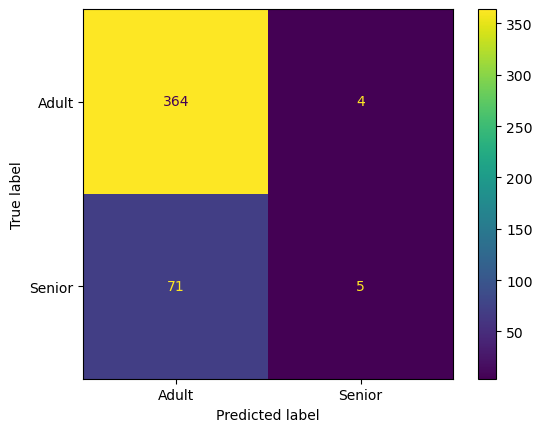

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay 
svc_pipe.fit(X_train,y_train)
test_confMatrix = ConfusionMatrixDisplay.from_estimator(
    svc_pipe,
    X_test,
    y_test,
    values_format="d",
)
test_confMatrix

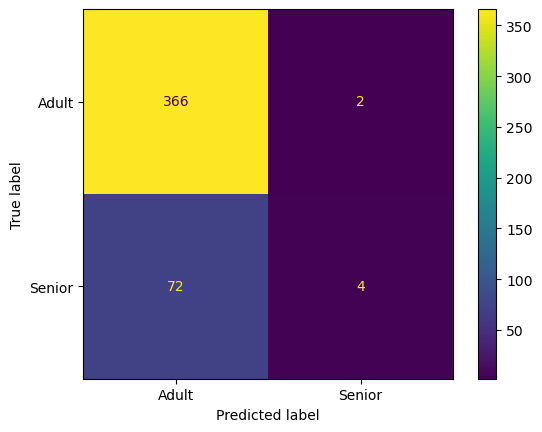

In [22]:
lr_pipe.fit(X_train,y_train)
test_confMatrix = ConfusionMatrixDisplay.from_estimator(
    lr_pipe,
    X_test,
    y_test,
    values_format="d",
)
test_confMatrix

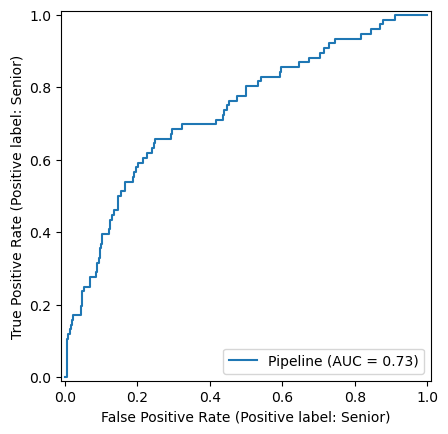

In [23]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    lr_pipe,
    X_test,
    y_test,
    pos_label= "Senior",
);

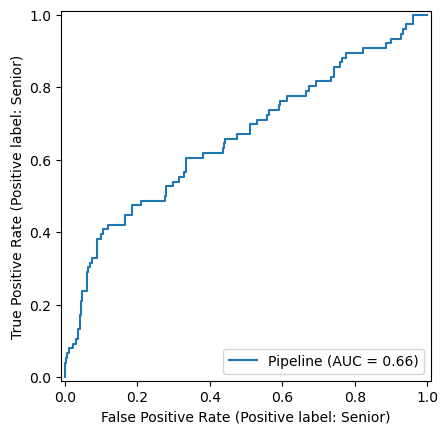

In [24]:
RocCurveDisplay.from_estimator(
    svc_pipe,
    X_test,
    y_test,
    pos_label= "Senior",
);

# Discussion

Insert discussion here

# References

Healthy Aging Center. 2022. "Aging Around the World." Colorado State University. https://www.research.colostate.edu/healthyagingcenter/2022/01/28/aging-around-the-world/.

Dinh, Andrew, and Susan Miertschin. 2016. “A Data-Driven Approach to Predicting Diabetes and Cardiovascular Disease with Machine Learning.” Semantic Scholar. https://www.semanticscholar.org/paper/A-data-driven-approach-to-predicting-diabetes-and-Dinh-Miertschin/01af1548ff1f3661d8bb813e8c35ee219a79ca9f.